Welcome to XGboost electirc boga loo, most of the code is coppied and pasted form RANDOMFOREST

In [1]:
# Import lib
import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from xgboost import XGBRegressor

# Import data, X and y for training
X_all_lf = pd.read_csv("data/forecast_data_lf.csv")
y_all = pd.read_csv("data/target_train.csv")

## Split into training and testing, solar and wind

In [2]:
#print(X_all_lf.shape) # (54336, 14)
#print(y_all.shape) # (54336, 5)
#display(X_all_lf)
#display(y_all)

from sklearn.model_selection import train_test_split

# Split into solar and wind traning and test
solar_features = ["valid_datetime",
                "dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature", 
                "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]
wind_features = ["valid_datetime",
                "dwd_RelativeHumidity", "dwd_WindDirection_100", "dwd_WindSpeed_100", 
                "ncep_RelativeHumidity", "ncep_WindDirection_100", "ncep_WindSpeed_100"]

X_solar = X_all_lf[solar_features]
X_wind = X_all_lf[wind_features]

y_solar = y_all["Solar_MWh_credit"]
y_wind = y_all["Wind_MWh_credit"]

X_solar_train, X_solar_test, y_solar_train, y_solar_test = train_test_split(
    X_solar, y_solar, test_size=0.2, random_state=42, shuffle=False
)

X_wind_train, X_wind_test, y_wind_train, y_wind_test = train_test_split(
    X_wind, y_wind, test_size=0.2, random_state=42, shuffle=False
)



## Feature Engineering

In [3]:
# Define functions 
def add_cyclic_time_features(df, dt_col="valid_datetime", drop_original=True):
    df = df.copy()
    df[dt_col] = pd.to_datetime(df[dt_col])

    df["hour_sin"] = np.sin(2*np.pi*(df[dt_col].dt.hour + df[dt_col].dt.minute/60)/24)
    df["hour_cos"] = np.cos(2*np.pi*(df[dt_col].dt.hour + df[dt_col].dt.minute/60)/24)
    df["weekday_sin"] = np.sin(2*np.pi*df[dt_col].dt.weekday/7)
    df["weekday_cos"] = np.cos(2*np.pi*df[dt_col].dt.weekday/7)
    df["month_sin"] = np.sin(2*np.pi*df[dt_col].dt.month/12)
    df["month_cos"] = np.cos(2*np.pi*df[dt_col].dt.month/12)

    if drop_original:
        df = df.drop(columns=dt_col)

    return df

def add_wind_direction_cyclic(df, wind_dir_columns, drop_original=True):
    df = df.copy()
    for col in wind_dir_columns:
        radians = np.deg2rad(df[col])
        df[f"{col}_sin"] = np.sin(radians)
        df[f"{col}_cos"] = np.cos(radians)
    
    if drop_original:
        df = df.drop(columns=wind_dir_columns)
    return df

def add_lag_features(df, columns, lags=[-2, -1, 0, 1, 2], drop_original=True):
    df = df.copy()
    
    for col in columns:
        for lag in lags:
            df[f"{col}_lag{lag}"] = df[col].shift(lag)

    if drop_original:
        df = df.drop(columns=columns)
    return df

def scale_features(df, scaler=None):
    df = df.copy()
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    if scaler is None:
        scaler = MinMaxScaler()
        df[numeric_cols] = scaler.fit_transform(df[numeric_cols])
    else:
        df[numeric_cols] = scaler.transform(df[numeric_cols])

    return df, scaler

# affected col
wind_lag_col = ["dwd_RelativeHumidity", "dwd_WindSpeed_100", "ncep_RelativeHumidity", "ncep_WindSpeed_100"]
solar_lag_col = ["dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
                "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature",]

# call functions for wind
X_wind_train = add_cyclic_time_features(df=X_wind_train)
X_wind_train = add_wind_direction_cyclic(df=X_wind_train, wind_dir_columns=["dwd_WindDirection_100", "ncep_WindDirection_100"])
X_wind_train = add_lag_features(df=X_wind_train, columns=wind_lag_col)
X_wind_train, wind_scale = scale_features(df=X_wind_train, scaler=None)

print(X_wind_train.head(0))

X_wind_test = add_cyclic_time_features(X_wind_test)
X_wind_test = add_wind_direction_cyclic(df=X_wind_test, wind_dir_columns=["dwd_WindDirection_100", "ncep_WindDirection_100"])
X_wind_test = add_lag_features(df=X_wind_test, columns=wind_lag_col)
X_wind_test, _ = scale_features(df=X_wind_test, scaler=wind_scale)

print(X_wind_test.head(0))

X_solar_train = add_cyclic_time_features(df=X_solar_train)
X_solar_train = add_lag_features(df=X_solar_train, columns=solar_lag_col)
X_solar_train, solar_scale = scale_features(df=X_solar_train, scaler=None)

print(X_solar_train.head(0))

X_solar_test = add_cyclic_time_features(df=X_solar_test)
X_solar_test = add_lag_features(df=X_solar_test, columns=solar_lag_col)
X_solar_test, _ = scale_features(df=X_solar_test, scaler=solar_scale)

print(X_solar_test.head(0))

X_solar_train = X_solar_train.ffill().bfill()
X_solar_test = X_solar_test.ffill().bfill()
X_wind_train = X_wind_train.ffill().bfill()
X_wind_test = X_wind_test.ffill().bfill()

print(f"\nNumber of NaN values: {X_solar_train.isna().sum().sum() + X_solar_test.isna().sum().sum() + X_wind_train.isna().sum().sum() + X_wind_test.isna().sum().sum()}")

Empty DataFrame
Columns: [hour_sin, hour_cos, weekday_sin, weekday_cos, month_sin, month_cos, dwd_WindDirection_100_sin, dwd_WindDirection_100_cos, ncep_WindDirection_100_sin, ncep_WindDirection_100_cos, dwd_RelativeHumidity_lag-2, dwd_RelativeHumidity_lag-1, dwd_RelativeHumidity_lag0, dwd_RelativeHumidity_lag1, dwd_RelativeHumidity_lag2, dwd_WindSpeed_100_lag-2, dwd_WindSpeed_100_lag-1, dwd_WindSpeed_100_lag0, dwd_WindSpeed_100_lag1, dwd_WindSpeed_100_lag2, ncep_RelativeHumidity_lag-2, ncep_RelativeHumidity_lag-1, ncep_RelativeHumidity_lag0, ncep_RelativeHumidity_lag1, ncep_RelativeHumidity_lag2, ncep_WindSpeed_100_lag-2, ncep_WindSpeed_100_lag-1, ncep_WindSpeed_100_lag0, ncep_WindSpeed_100_lag1, ncep_WindSpeed_100_lag2]
Index: []

[0 rows x 30 columns]
Empty DataFrame
Columns: [hour_sin, hour_cos, weekday_sin, weekday_cos, month_sin, month_cos, dwd_WindDirection_100_sin, dwd_WindDirection_100_cos, ncep_WindDirection_100_sin, ncep_WindDirection_100_cos, dwd_RelativeHumidity_lag-2, dwd

Great, every feature is lined up, move on to modeling

In [ ]:
# Checking 
#print(X_solar_train.shape)
#print(X_solar_test.shape)
#print(y_solar_test.shape)
#print(y_solar_train.shape)
#print(X_wind_train.shape)
#print(X_wind_test.shape)
#print(y_wind_train.shape)
#print(y_wind_test.shape)

# Define scaling target function
def scale_target(series, scaler=None):
    # convert to numpy array and reshape
    values = series.values.reshape(-1,1)
    
    # apply scaling
    if scaler is None:
        scaler = MinMaxScaler()
        scaled_values = scaler.fit_transform(values)
    else:
        scaled_values = scaler.transform(values)
    
    # convert back to Series with original index and name
    scaled_series = pd.Series(scaled_values.flatten(), 
                            index=series.index, 
                            name=series.name)
    
    return scaled_series, scaler

# Define functions for quantiles copied form "getting started" 
def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df):
    scores = [
        pinball(
            y=df["total_generation_MWh"],
            q=df[f"q{qu}"],
            alpha=qu/100
        ).mean()
        for qu in range(10, 100, 10)
    ]
    return np.mean(scores)

# scale target
y_solar_train_scaled, solar_scale_y = scale_target(series=y_solar_train, scaler=None)
y_wind_train_scaled, wind_scale_y = scale_target(series=y_wind_train, scaler=None)

# Define quantiles
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

solar_models = {
    q: XGBRegressor(objective="reg:quantileerror", quantile_alpha=q).fit(X_solar_train, y_solar_train_scaled)
    for q in quantiles
}
wind_models = {
    q: XGBRegressor(objective="reg:quantileerror", quantile_alpha=q).fit(X_wind_train, y_wind_train_scaled)
    for q in quantiles
}

solar_preds = {
    q: solar_scale_y.inverse_transform(solar_models[q].predict(X_solar_test).reshape(-1, 1)).ravel()
    for q in quantiles
}
wind_preds = {
    q: wind_scale_y.inverse_transform(wind_models[q].predict(X_wind_test).reshape(-1, 1)).ravel()
    for q in quantiles
}

#  solar 
df_solar = pd.DataFrame({
    "total_generation_MWh": y_solar_test,
    **{f"q{int(q*100)}": solar_preds[q] for q in quantiles}
})

# wind
df_wind = pd.DataFrame({
    "total_generation_MWh": y_wind_test,
    **{f"q{int(q*100)}": wind_preds[q] for q in quantiles}
})

# combined
df_preds = pd.DataFrame({
    "total_generation_MWh": y_solar_test + y_wind_test,
    **{f"q{int(q*100)}": solar_preds[q] + wind_preds[q] for q in quantiles}
})

# score all three
score_total = pinball_score(df_preds)
score_solar = pinball_score(df_solar)
score_wind  = pinball_score(df_wind)

print(f"Pinball score (Total): {score_total:.4f}")
print(f"Pinball score (Solar): {score_solar:.4f}")
print(f"Pinball score (Wind):  {score_wind:.4f}")

# Pinball score without Gridsearch and no Scaler: 27.715809955091 (MinMax Scaler applied on X)
# Pinball score without Gridsearch and MinMax scaler for both X and y: 27.68417049026762
# Pinball score without Gridsearch: 27.701756428356788 (StandardScaler y, MinMaxScaler X)
# Pinball score without Gridsearch: 27.6950224508966 (StandardScaler X and Y)

# MinMax Scaler typically runs for less
# typical run time 30 seconds 

# for report
# Pinball score
# Pinball score (Total): 27.6842
# Pinball score (Solar): 11.3546
# Pinball score (Wind):  21.8306

Pinball score (Total): 27.6842
Pinball score (Solar): 11.3546
Pinball score (Wind):  21.8306


In [6]:
# Testing of alternatve metrics
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error, mean_squared_error, r2_score

# Symetric Mean Absolute Percentage Error
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0  # avoid division by zero
    return 100 * np.mean(diff)

# Mean Absolute Percentage Error
# own function to forcefully ingore division by zero
def mape(y_true, y_pred):
    mask = y_true != 0
    return 100 * np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask]))

# Continuous Ranked Probability Score
def crps(y_true, quantile_preds, quantiles):
    y = y_true.reshape(-1, 1)
    q_vals = np.array(quantiles).reshape(1, -1)
    indicator = (y < quantile_preds).astype(float)
    return np.mean((indicator - q_vals) * (quantile_preds - y))

# Weighted Interval Score
def wis(y_true, quantile_preds, quantiles):
    # Assumes symmetric quantile pairs around the median
    lower_idxs = list(range(len(quantiles) // 2))
    upper_idxs = list(range(len(quantiles) - 1, len(quantiles) // 2 - 1, -1))
    
    wis_total = 0.0
    for l_idx, u_idx in zip(lower_idxs, upper_idxs):
        alpha = quantiles[u_idx] - quantiles[l_idx]
        lower = quantile_preds[:, l_idx]
        upper = quantile_preds[:, u_idx]
        range_ = upper - lower
        below = np.maximum(lower - y_true, 0)
        above = np.maximum(y_true - upper, 0)
        wis_total += range_ + 2 / alpha * below + 2 / alpha * above

    return np.mean(wis_total / len(lower_idxs))

def evaluate_forecast(df, quantiles):
    y_true = df["total_generation_MWh"].values
    y_pred = df["q50"].values
    quantile_preds = np.stack([df[f"q{int(q*100)}"].values for q in quantiles], axis=-1)
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mape_ = mape(y_true, y_pred)
    smape_ = smape(y_true, y_pred)
    crps_ = crps(y_true, quantile_preds, quantiles)
    wis_ = wis(y_true, quantile_preds, quantiles)

    return {
        "MAE": mae,
        "MAPE": mape_,
        "SMAPE": smape_,
        "RMSE": rmse,
        "R2": r2,
        "CRPS": crps_,
        "WIS": wis_
    }

# No Search, training 
metrics_solar = evaluate_forecast(df_solar, quantiles)
metrics_wind = evaluate_forecast(df_wind, quantiles)
metrics_combined = evaluate_forecast(df_preds, quantiles)

print("Solar:", metrics_solar)
print("Wind:", metrics_wind)
print("Combined:", metrics_combined)

#Solar: {'MAE': 28.743873956862092, 'MAPE': np.float64(27186728.921660107), 'SMAPE': np.float64(98.17594472908422), 'RMSE': np.float64(55.6866595274709), 'R2': 0.9394122894878447, 'CRPS': np.float64(11.354604389682853), 'WIS': np.float64(131.61015077536078)}
#Wind: {'MAE': 54.74370623495566, 'MAPE': np.float64(1042.997453834903), 'SMAPE': np.float64(51.22014908733923), 'RMSE': np.float64(88.00419483241015), 'R2': 0.8168651877064024, 'CRPS': np.float64(21.830622888006904), 'WIS': np.float64(247.21672584470676)}
#Combined: {'MAE': 69.54431019612687, 'MAPE': np.float64(18146.88132430459), 'SMAPE': np.float64(32.075535064013486), 'RMSE': np.float64(104.13702850713067), 'R2': 0.8718690829794065, 'CRPS': np.float64(27.684170490267626), 'WIS': np.float64(317.1178180522531)}

Solar: {'MAE': 28.743873956862092, 'MAPE': np.float64(27186728.921660107), 'SMAPE': np.float64(98.17594472908422), 'RMSE': np.float64(55.6866595274709), 'R2': 0.9394122894878447, 'CRPS': np.float64(11.354604389682853), 'WIS': np.float64(131.61015077536078)}
Wind: {'MAE': 54.74370623495566, 'MAPE': np.float64(1042.997453834903), 'SMAPE': np.float64(51.22014908733923), 'RMSE': np.float64(88.00419483241015), 'R2': 0.8168651877064024, 'CRPS': np.float64(21.830622888006904), 'WIS': np.float64(247.21672584470676)}
Combined: {'MAE': 69.54431019612687, 'MAPE': np.float64(18146.88132430459), 'SMAPE': np.float64(32.075535064013486), 'RMSE': np.float64(104.13702850713067), 'R2': 0.8718690829794065, 'CRPS': np.float64(27.684170490267626), 'WIS': np.float64(317.1178180522531)}


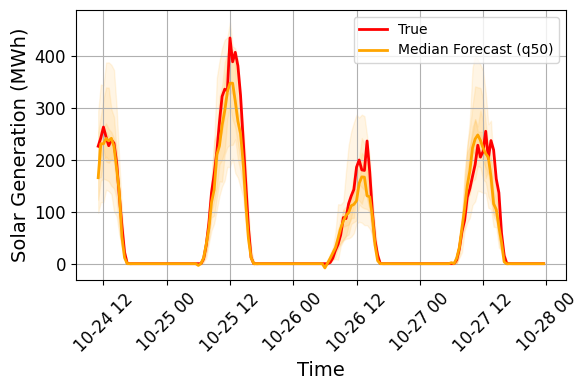

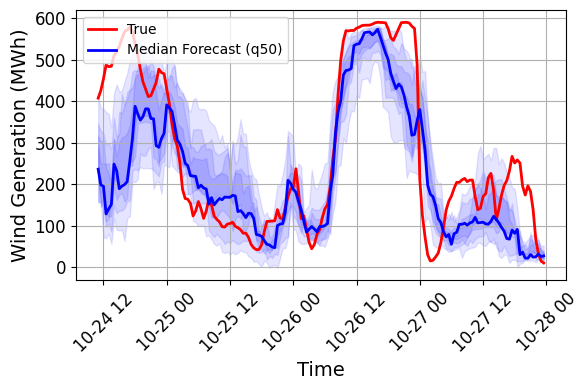

In [ ]:
# Plotting
n_q = len(quantiles)
num_half_h = 170
t_test = pd.to_datetime(y_all["dtm"].values)

# SUNNY D
t_slice = t_test[-num_half_h:]
y_true_slice = y_solar_test.values[-num_half_h:]
y_quantile_slice = {
    q: preds[-num_half_h:]
    for q, preds in solar_preds.items()
}

plt.figure(figsize=(6, 4))

plt.plot(t_slice, y_true_slice, label='True', color='red', linewidth=2)

df_quant = pd.DataFrame(y_quantile_slice)
df_quant = df_quant[sorted(df_quant.columns)]

# Plot quantile bands
for i in range(n_q // 2):
    lower = df_quant.iloc[:, i]
    upper = df_quant.iloc[:, -(i + 1)]
    plt.fill_between(t_slice, lower, upper, color='orange', alpha=0.1)

# Median line
plt.plot(t_slice, df_quant[0.5], label='Median Forecast (q50)', color='orange', linewidth=2)

plt.xlabel("Time", fontsize=14)
plt.ylabel("Solar Generation (MWh)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# save to EPS ? 
#plt.savefig("quantile_solar_forecast_RFQR.eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()

# WINDY BOY
y_true_slice = y_wind_test.values[-num_half_h:]
y_quantile_slice = {
    q: preds[-num_half_h:]
    for q, preds in wind_preds.items()
} 

plt.figure(figsize=(6, 4))

plt.plot(t_slice, y_true_slice, label='True', color='red', linewidth=2)

df_quant = pd.DataFrame(y_quantile_slice)
df_quant = df_quant[sorted(df_quant.columns)]

# Plot symmetric quantile bands (e.g. q10–q90, q20–q80, ...)
for i in range(n_q // 2):
    lower = df_quant.iloc[:, i]
    upper = df_quant.iloc[:, -(i + 1)]
    plt.fill_between(t_slice, lower, upper, color='blue', alpha=0.1)

# Median line (q50)
plt.plot(t_slice, df_quant[0.5], label="Median Forecast (q50)", color="blue", linewidth=2)

plt.xlabel("Time", fontsize=14)
plt.ylabel("Wind Generation (MWh)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()

# EPS ?
#plt.savefig("quantile_wind_forecast_RFQR.eps", format='eps', dpi=300, bbox_inches='tight')
# it's shit, don't use it 

plt.show()


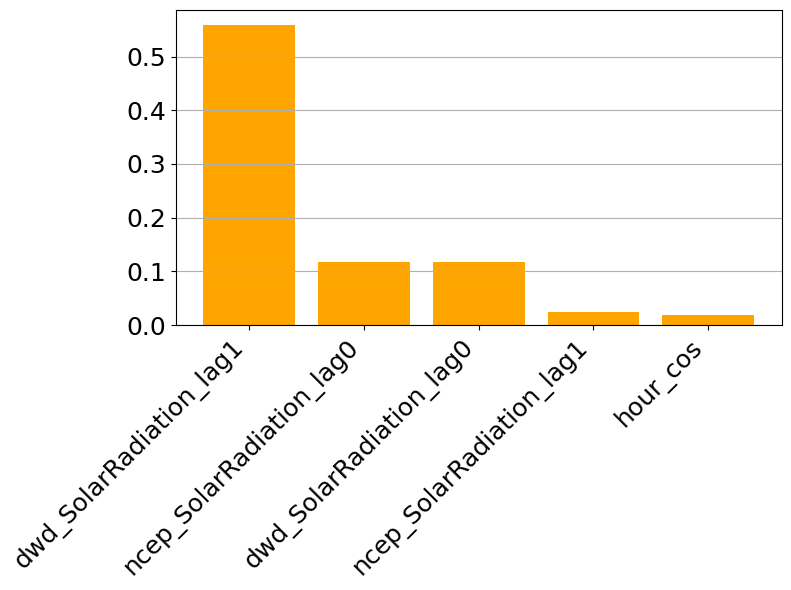

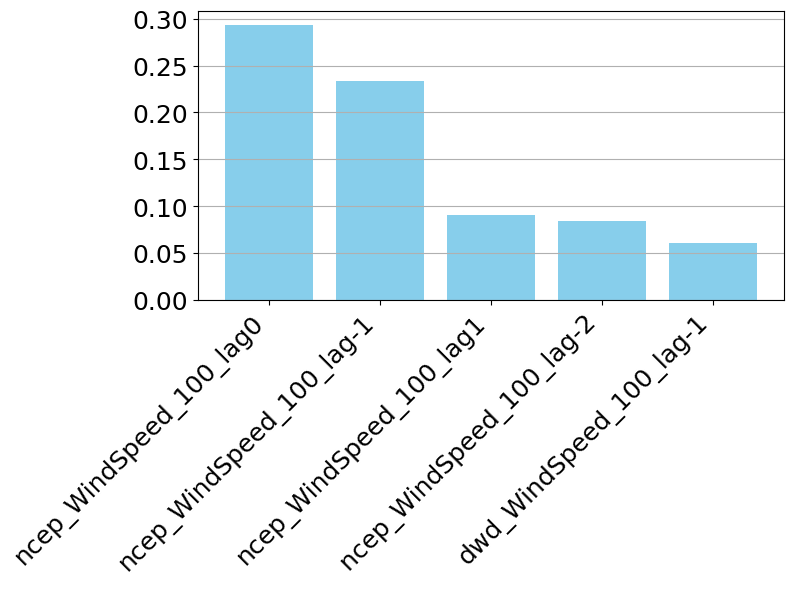

In [15]:
# feautre importance
# taken from previously shown headers 
feature_names_solar = [  
    "hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "month_sin", "month_cos", 
    "dwd_CloudCover_lag-2", "dwd_CloudCover_lag-1", "dwd_CloudCover_lag0", "dwd_CloudCover_lag1", "dwd_CloudCover_lag2",
    "dwd_SolarRadiation_lag-2", "dwd_SolarRadiation_lag-1", "dwd_SolarRadiation_lag0", "dwd_SolarRadiation_lag1", "dwd_SolarRadiation_lag2",
    "dwd_Temperature_lag-2", "dwd_Temperature_lag-1", "dwd_Temperature_lag0", "dwd_Temperature_lag1", "dwd_Temperature_lag2",
    "ncep_CloudCover_lag-2", "ncep_CloudCover_lag-1", "ncep_CloudCover_lag0", "ncep_CloudCover_lag1", "ncep_CloudCover_lag2", 
    "ncep_SolarRadiation_lag-2", "ncep_SolarRadiation_lag-1", "ncep_SolarRadiation_lag0", "ncep_SolarRadiation_lag1", "ncep_SolarRadiation_lag2",
    "ncep_Temperature_lag-2", "ncep_Temperature_lag-1", "ncep_Temperature_lag0", "ncep_Temperature_lag1", "ncep_Temperature_lag2"
]

feature_names_wind = [
    "hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "month_sin", "month_cos", 
    "dwd_WindDirection_100_sin", "dwd_WindDirection_100_cos", "ncep_WindDirection_100_sin", "ncep_WindDirection_100_cos", 
    "dwd_RelativeHumidity_lag-2", "dwd_RelativeHumidity_lag-1", "dwd_RelativeHumidity_lag0", "dwd_RelativeHumidity_lag1", "dwd_RelativeHumidity_lag2", 
    "dwd_WindSpeed_100_lag-2", "dwd_WindSpeed_100_lag-1", "dwd_WindSpeed_100_lag0", "dwd_WindSpeed_100_lag1", "dwd_WindSpeed_100_lag2", 
    "ncep_RelativeHumidity_lag-2"," ncep_RelativeHumidity_lag-1", "ncep_RelativeHumidity_lag0", "ncep_RelativeHumidity_lag1", "ncep_RelativeHumidity_lag2", 
   " ncep_WindSpeed_100_lag-2", "ncep_WindSpeed_100_lag-1", "ncep_WindSpeed_100_lag0", "ncep_WindSpeed_100_lag1", "ncep_WindSpeed_100_lag2"
]

# mean over all models
importances_solar = np.array([model.feature_importances_ for model in solar_models.values()])
importances_wind = np.array([model.feature_importances_ for model in wind_models.values()])

mean_importance_solar = importances_solar.mean(axis=0)
mean_importance_wind = importances_wind.mean(axis=0)

# solar top 5
indices_solar = np.argsort(mean_importance_solar)[::-1][:5]
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.bar(range(5), mean_importance_solar[indices_solar], color='orange')
plt.xticks(range(5), [feature_names_solar[i] for i in indices_solar], rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.grid(axis='y')
plt.savefig("XGB_solar_features_avg.eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()

# wind top 5
indices_wind = np.argsort(mean_importance_wind)[::-1][:5]
plt.figure(figsize=(8, 6))
plt.rcParams.update({'font.size': 10})
plt.bar(range(5), mean_importance_wind[indices_wind], color='skyblue')
plt.xticks(range(5), [feature_names_wind[i] for i in indices_wind], rotation=45, ha='right', fontsize=18)
plt.yticks(fontsize=18)
plt.tight_layout()
plt.grid(axis='y')
plt.savefig("XGB_wind_features_avg.eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# Hyperparamter tuning using Random Search
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer

# Competition pinball functions
def pinball(y, q, alpha):
    return (y - q) * alpha * (y >= q) + (q - y) * (1 - alpha) * (y < q)

def pinball_score(df):
    scores = [
        pinball(df["total_generation_MWh"], df[f"q{qu}"], qu / 100).mean()
        for qu in range(10, 100, 10)
    ]
    return np.mean(scores)

# Custom pinball functions
def pinball_loss(y_true, y_pred, alpha):
    err = y_true - y_pred
    return np.mean(np.where(err >= 0, alpha * err, (1 - alpha) * -err))

def make_pinball_scorer(alpha):
    return make_scorer(pinball_loss, alpha=alpha, greater_is_better=False)

# Train models with search
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
solar_models = {}
wind_models = {}
solar_preds = {}
wind_preds = {}

param_dist = {
    "learning_rate": np.linspace(0.01, 0.3, 10),
    "max_depth": np.arange(3, 10),
    "n_estimators": np.arange(50, 500, 50),
    "colsample_bytree": np.linspace(0.5, 1.0, 5),
    "reg_alpha": np.linspace(0, 10, 5),
    "reg_lambda": np.linspace(0, 10, 5),
    "min_child_weight": np.arange(1, 10),
    "gamma": np.linspace(0, 5, 5)
}

# scale targets 
y_solar_train_scaled, solar_scale_y = scale_target(series=y_solar_train, scaler=None)
y_wind_train_scaled, wind_scale_y = scale_target(series=y_wind_train, scaler=None)

for q in quantiles:
    print(f"Training quantile {q}")

    # Solar
    base_model = XGBRegressor(objective="reg:quantileerror", quantile_alpha=q, random_state=42)
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=30, 
        scoring=make_pinball_scorer(alpha=q),
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    random_search.fit(X_solar_train, y_solar_train_scaled)
    solar_models[q] = random_search.best_estimator_
    solar_preds[q] = random_search.best_estimator_.predict(X_solar_test)

    # Wind
    base_model = XGBRegressor(objective="reg:quantileerror", quantile_alpha=q, random_state=42)
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=30, 
        scoring=make_pinball_scorer(alpha=q),
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )
    random_search.fit(X_wind_train, y_wind_train_scaled)
    wind_models[q] = random_search.best_estimator_
    wind_preds[q] = random_search.best_estimator_.predict(X_wind_test)

# unscale results and overwrite the previous 
solar_preds = {
    q: solar_scale_y.inverse_transform(solar_models[q].predict(X_solar_test).reshape(-1, 1)).ravel()
    for q in quantiles
}
wind_preds = {
    q: wind_scale_y.inverse_transform(wind_models[q].predict(X_wind_test).reshape(-1, 1)).ravel()
    for q in quantiles
}

df_solar = pd.DataFrame({
    "total_generation_MWh": y_solar_test,
    **{f"q{int(q*100)}": solar_preds[q] for q in quantiles}
})

# wind
df_wind = pd.DataFrame({
    "total_generation_MWh": y_wind_test,
    **{f"q{int(q*100)}": wind_preds[q] for q in quantiles}
})

# combined
df_preds = pd.DataFrame({
    "total_generation_MWh": y_solar_test + y_wind_test,
    **{f"q{int(q*100)}": solar_preds[q] + wind_preds[q] for q in quantiles}
})

# score all three
score_total = pinball_score(df_preds)
score_solar = pinball_score(df_solar)
score_wind  = pinball_score(df_wind)

print(f"Pinball score (Total): {score_total:.4f}")
print(f"Pinball score (Solar): {score_solar:.4f}")
print(f"Pinball score (Wind):  {score_wind:.4f}")

# it took 21 min to get a new score of 27.155133575567888, (X scaled, y not scaled)
# it took 21 min to get a new score of 27.155347654001854, (X scaled, y scaled)

# for reports
# Pinball score (Total): 27.1553
# Pinball score (Solar): 11.2114
# Pinball score (Wind):  21.0193

Training quantile 0.1
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Training quantile 0.2
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Training quantile 0.3
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Training quantile 0.4
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Training quantile 0.5
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Training quantile 0.6
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Training quantile 0.7
Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 

In [8]:
# Calculate metrics for, with search using training  
metrics_solar = evaluate_forecast(df_solar, quantiles)
metrics_wind = evaluate_forecast(df_wind, quantiles)
metrics_combined = evaluate_forecast(df_preds, quantiles)

print("Solar:", metrics_solar)
print("Wind:", metrics_wind)
print("Combined:", metrics_combined)

#Solar: {'MAE': 28.247420932644022, 'MAPE': np.float64(67460309.63710794), 'SMAPE': np.float64(97.18876484711558), 'RMSE': np.float64(55.22541170159285), 'R2': 0.9404118183887368, 'CRPS': np.float64(11.211447526188026), 'WIS': np.float64(131.08741121377068)}
#Wind: {'MAE': 52.93332936384521, 'MAPE': np.float64(1041.6948604268443), 'SMAPE': np.float64(49.94031485809207), 'RMSE': np.float64(86.56205472348213), 'R2': 0.8228181330768022, 'CRPS': np.float64(21.019285106962617), 'WIS': np.float64(242.67807432858694)}
#Combined: {'MAE': 68.08234878763508, 'MAPE': np.float64(13877.301962620064), 'SMAPE': np.float64(31.20978483613792), 'RMSE': np.float64(102.78978178343932), 'R2': 0.8751629606904755, 'CRPS': np.float64(27.15534765400185), 'WIS': np.float64(316.1770716115719)}

Solar: {'MAE': 28.247420932644022, 'MAPE': np.float64(67460309.63710794), 'SMAPE': np.float64(97.18876484711558), 'RMSE': np.float64(55.22541170159285), 'R2': 0.9404118183887368, 'CRPS': np.float64(11.211447526188026), 'WIS': np.float64(131.08741121377068)}
Wind: {'MAE': 52.93332936384521, 'MAPE': np.float64(1041.6948604268443), 'SMAPE': np.float64(49.94031485809207), 'RMSE': np.float64(86.56205472348213), 'R2': 0.8228181330768022, 'CRPS': np.float64(21.019285106962617), 'WIS': np.float64(242.67807432858694)}
Combined: {'MAE': 68.08234878763508, 'MAPE': np.float64(13877.301962620064), 'SMAPE': np.float64(31.20978483613792), 'RMSE': np.float64(102.78978178343932), 'R2': 0.8751629606904755, 'CRPS': np.float64(27.15534765400185), 'WIS': np.float64(316.1770716115719)}


In [9]:
# prepross_comp mostly copied from RandomForest

start_date_comp = pd.Timestamp("2024-02-20 00:00:00+00:00")
end_date_comp = pd.Timestamp("2024-05-19 23:30:00+00:00")

energy_data_2 = pd.read_csv("data_comp/Energy_Data_20240119_20240519.csv")
energy_data_2["dtm"] = pd.to_datetime(energy_data_2["dtm"])

filtered_data = energy_data_2[
    (energy_data_2["dtm"] >= start_date_comp) &
    (energy_data_2["dtm"] <= end_date_comp)
].copy()

filtered_data["Wind_MWh_credit"] = 0.5*filtered_data["Wind_MW"] - filtered_data["boa_MWh"]
filtered_data["Solar_MWh_credit"] = 0.5*filtered_data["Solar_MW"]
filtered_data["total_generation_MWh"] = filtered_data["Wind_MWh_credit"] + filtered_data["Solar_MWh_credit"]

y_time = filtered_data["dtm"].values
y_time = pd.to_datetime(y_time)

y_true_wind_comp = filtered_data["Wind_MWh_credit"].values
y_true_solar_comp = filtered_data["Solar_MWh_credit"].values
y_true_comp = filtered_data["total_generation_MWh"].values

model_table = pd.read_csv("data_comp/forecast_data_merged_comp.csv")
model_table["reference_time"] = pd.to_datetime(model_table["reference_time"])
model_table["valid_time"] = pd.to_datetime(model_table["valid_time"])

X_latest_forcast_comp = pd.DataFrame() 
first_day = pd.Timestamp("2024-01-29 00:00:00+00:00")
num_day = model_table["reference_time"].dt.date.nunique()

for d in range(num_day):
       start = (first_day + timedelta(hours=18)) + timedelta(days=d)
       end = start + timedelta(hours=24)
       mask = (model_table["reference_time"] == start) &\
              (model_table["valid_time"] >= start + timedelta(hours=6)) &\
              (model_table["valid_time"] < end + + timedelta(hours=6))
       X_latest_forcast_comp = pd.concat([X_latest_forcast_comp, model_table.loc[mask]])

X_latest_forcast_comp = X_latest_forcast_comp.rename(columns={
    "valid_time": "valid_datetime"})

filtered_X_lf = X_latest_forcast_comp[(X_latest_forcast_comp["valid_datetime"] >= start_date_comp) & (X_latest_forcast_comp["valid_datetime"] <= end_date_comp)]

wind_features = ["valid_datetime", "dwd_RelativeHumidity", "dwd_WindDirection_100", "dwd_WindSpeed_100",
                "ncep_RelativeHumidity", "ncep_WindDirection_100", "ncep_WindSpeed_100"]

solar_features = ["valid_datetime","dwd_CloudCover", "dwd_SolarDownwardRadiation", "dwd_Temperature",
                "ncep_CloudCover", "ncep_SolarDownwardRadiation", "ncep_Temperature"]

X_comp_solar_lf = filtered_X_lf[solar_features]
X_comp_wind_lf = filtered_X_lf[wind_features]

# ADD feature engineering
X_comp_solar = add_cyclic_time_features(df=X_comp_solar_lf)
X_comp_solar = add_lag_features(df=X_comp_solar, columns=solar_lag_col)
X_comp_solar, _ = scale_features(df=X_comp_solar, scaler=solar_scale)

print(X_comp_solar.head(0))

X_comp_wind = add_cyclic_time_features(df=X_comp_wind_lf)
X_comp_wind = add_wind_direction_cyclic(df=X_comp_wind, wind_dir_columns=["dwd_WindDirection_100", "ncep_WindDirection_100"])
X_comp_wind = add_lag_features(df=X_comp_wind, columns=wind_lag_col)
X_comp_wind, _ = scale_features(df=X_comp_wind, scaler=wind_scale)

print(X_comp_wind.head(0))

# fill in NaN values
X_comp_solar = X_comp_solar.ffill().bfill()
X_comp_wind = X_comp_wind.ffill().bfill()


Empty DataFrame
Columns: [hour_sin, hour_cos, weekday_sin, weekday_cos, month_sin, month_cos, dwd_CloudCover_lag-2, dwd_CloudCover_lag-1, dwd_CloudCover_lag0, dwd_CloudCover_lag1, dwd_CloudCover_lag2, dwd_SolarDownwardRadiation_lag-2, dwd_SolarDownwardRadiation_lag-1, dwd_SolarDownwardRadiation_lag0, dwd_SolarDownwardRadiation_lag1, dwd_SolarDownwardRadiation_lag2, dwd_Temperature_lag-2, dwd_Temperature_lag-1, dwd_Temperature_lag0, dwd_Temperature_lag1, dwd_Temperature_lag2, ncep_CloudCover_lag-2, ncep_CloudCover_lag-1, ncep_CloudCover_lag0, ncep_CloudCover_lag1, ncep_CloudCover_lag2, ncep_SolarDownwardRadiation_lag-2, ncep_SolarDownwardRadiation_lag-1, ncep_SolarDownwardRadiation_lag0, ncep_SolarDownwardRadiation_lag1, ncep_SolarDownwardRadiation_lag2, ncep_Temperature_lag-2, ncep_Temperature_lag-1, ncep_Temperature_lag0, ncep_Temperature_lag1, ncep_Temperature_lag2]
Index: []

[0 rows x 36 columns]
Empty DataFrame
Columns: [hour_sin, hour_cos, weekday_sin, weekday_cos, month_sin, mon

In [43]:
# Single run test of most resently run model
#solar_preds_new = {q: model.predict(X_comp_solar) for q, model in solar_models.items()}
#wind_preds_new = {q: model.predict(X_comp_wind) for q, model in wind_models.items()}

solar_preds_new = {
    q: solar_scale_y.inverse_transform(solar_models[q].predict(X_comp_solar).reshape(-1, 1)).ravel()
    for q in quantiles
}
wind_preds_new = {
    q: wind_scale_y.inverse_transform(wind_models[q].predict(X_comp_wind).reshape(-1, 1)).ravel()
    for q in quantiles
}

df_solar_new = pd.DataFrame({
    "total_generation_MWh": y_true_solar_comp,
    **{f"q{int(q*100)}": solar_preds_new[q] for q in quantiles}
})

# wind
df_wind_new = pd.DataFrame({
    "total_generation_MWh": y_true_wind_comp,
    **{f"q{int(q*100)}": wind_preds_new[q] for q in quantiles}
})

# combined
df_preds_new = pd.DataFrame({
    "total_generation_MWh": y_true_comp,
    **{f"q{int(q*100)}": solar_preds_new[q] + wind_preds_new[q] for q in quantiles}
})

# score all three
score_total = pinball_score(df_preds_new)
score_solar = pinball_score(df_solar_new)
score_wind  = pinball_score(df_wind_new)

print(f"Pinball score Compition (Total): {score_total:.4f}")
print(f"Pinball score Compition (Solar): {score_solar:.4f}")
print(f"Pinball score Compition (Wind):  {score_wind:.4f}")

# NO REMIT
# Pinball score 49.06130, both X and y MinMaxscaled no Search
# Pinball score 46.69385, both X and y MinMaxscaled with Search

# for report
# NO REMIT with search
#Pinball score Compition (Total): 46.6938
#Pinball score Compition (Solar): 14.4788
#Pinball score Compition (Wind):  46.9183

# NO REMIT without search
#Pinball score Compition (Total): 49.0613
#Pinball score Compition (Solar): 14.5746
#Pinball score Compition (Wind):  49.8876

Pinball score Compition (Total): 46.6938
Pinball score Compition (Solar): 14.4788
Pinball score Compition (Wind):  46.9183


In [ ]:
# Cacluate METRICS
metrics_solar = evaluate_forecast(df_solar_new, quantiles)
metrics_wind = evaluate_forecast(df_wind_new, quantiles)
metrics_combined = evaluate_forecast(df_preds_new, quantiles)

print("Solar:", metrics_solar)
print("Wind:", metrics_wind)
print("Combined:", metrics_combined)

# NO REMIT, No search
#Solar: {'MAE': 36.6008632696401, 'MAPE': np.float64(16417404.86791675), 'SMAPE': np.float64(109.34510697418445), 'RMSE': np.float64(77.06929821930994), 'R2': 0.8809229581503759, 'CRPS': np.float64(14.574564977067322), 'WIS': np.float64(164.94600140657906)}
#Wind: {'MAE': 113.77134517014814, 'MAPE': np.float64(548.6986672327272), 'SMAPE': np.float64(60.499581344931485), 'RMSE': np.float64(146.76505013363968), 'R2': 0.03381263788951783, 'CRPS': np.float64(49.88762019442205), 'WIS': np.float64(547.7368371065979)}
#Combined: {'MAE': 116.89990233735864, 'MAPE': np.float64(391.92189190333136), 'SMAPE': np.float64(41.63203355059209), 'RMSE': np.float64(148.82987241880213), 'R2': 0.6567967339286437, 'CRPS': np.float64(49.0613009164159), 'WIS': np.float64(547.9527604931569)}

# NO REMIT, with search
#Solar: {'MAE': 36.13761989473823, 'MAPE': np.float64(9872374.07812566), 'SMAPE': np.float64(108.6501487641673), 'RMSE': np.float64(75.30158538061205), 'R2': 0.8863227737681374, 'CRPS': np.float64(14.478761773194323), 'WIS': np.float64(167.48660220270582)}
#Wind: {'MAE': 112.07123779310923, 'MAPE': np.float64(474.35673043184926), 'SMAPE': np.float64(59.50937528489305), 'RMSE': np.float64(146.1003455084464), 'R2': 0.0425446196150332, 'CRPS': np.float64(46.91831717084684), 'WIS': np.float64(527.0366564823386)}
#Combined: {'MAE': 115.08920117013913, 'MAPE': np.float64(392.6605193549675), 'SMAPE': np.float64(40.580453775735364), 'RMSE': np.float64(147.4414220917841), 'R2': 0.6631704265513317, 'CRPS': np.float64(46.693849859319826), 'WIS': np.float64(535.8433321188955)}


Solar: {'MAE': 36.13761989473823, 'MAPE': np.float64(9872374.07812566), 'SMAPE': np.float64(108.6501487641673), 'RMSE': np.float64(75.30158538061205), 'R2': 0.8863227737681374, 'CRPS': np.float64(14.478761773194323), 'WIS': np.float64(167.48660220270582)}
Wind: {'MAE': 112.07123779310923, 'MAPE': np.float64(474.35673043184926), 'SMAPE': np.float64(59.50937528489305), 'RMSE': np.float64(146.1003455084464), 'R2': 0.0425446196150332, 'CRPS': np.float64(46.91831717084684), 'WIS': np.float64(527.0366564823386)}
Combined: {'MAE': 115.08920117013913, 'MAPE': np.float64(392.6605193549675), 'SMAPE': np.float64(40.580453775735364), 'RMSE': np.float64(147.4414220917841), 'R2': 0.6631704265513317, 'CRPS': np.float64(46.693849859319826), 'WIS': np.float64(535.8433321188955)}


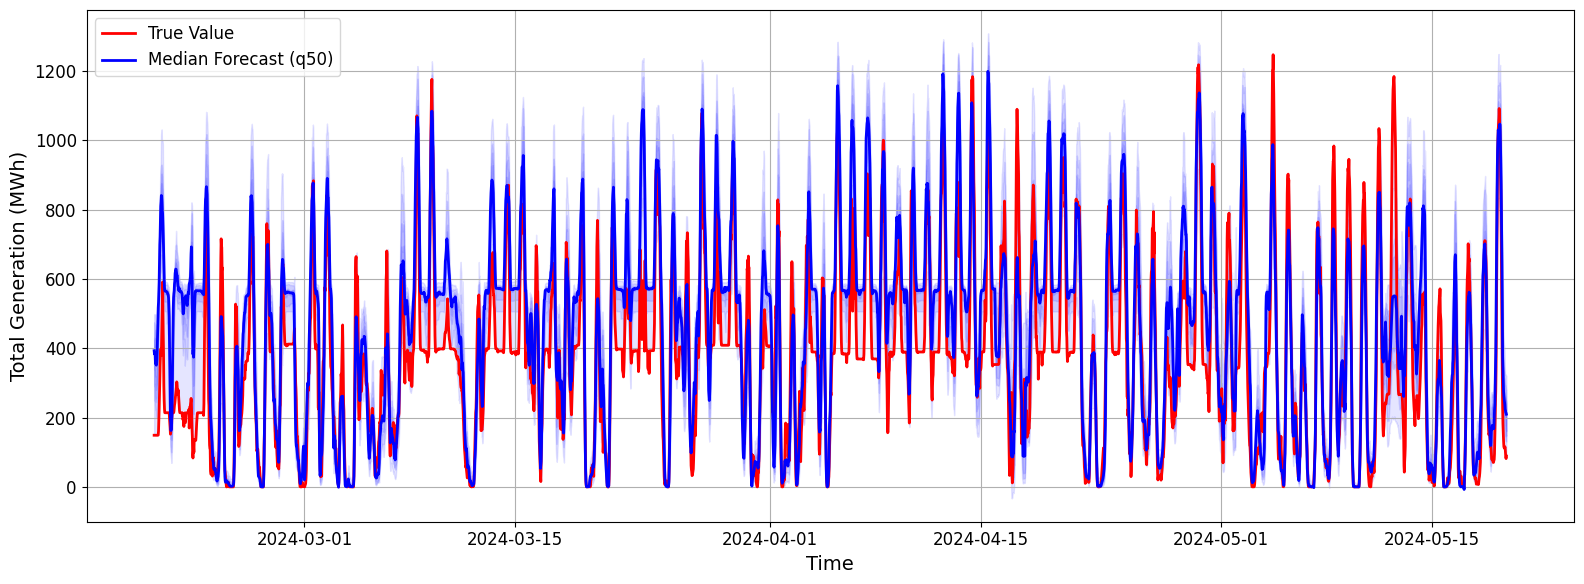

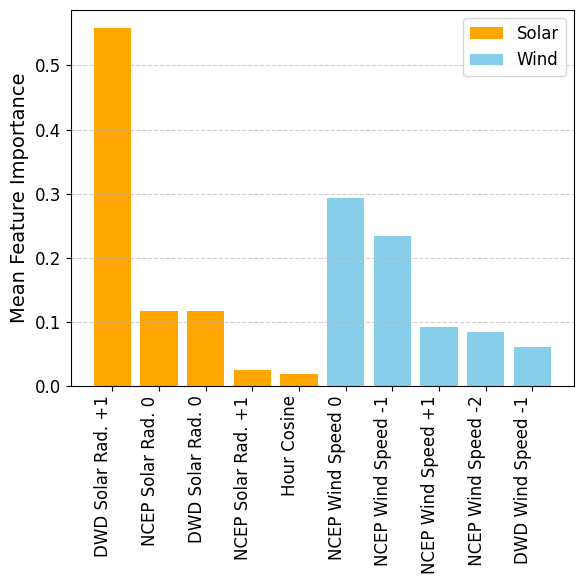

In [ ]:
# plot and get feature importance 
time = filtered_data["dtm"].values 
n_q = len(quantiles)

# does size matter? 
plt.figure(figsize=(16, 6))
# plot true 
plt.plot(time, y_true_comp, label='True Value', linewidth=2,  color="red")

# plot symmetric quantile bands (e.g. q10–q90, q20–q80, ...)
for i in range(n_q // 2):
    lower = df_preds_new.iloc[:, i]
    upper = df_preds_new.iloc[:, -(i + 1)]
    plt.fill_between(time, lower, upper, color='blue', alpha=0.1)

# plot median overlapp previous median 
plt.plot(time, df_preds_new["q50"].values, label="Median Forecast (q50)", linewidth=2, color="blue",)

plt.xlabel("Time", fontsize=14)
plt.ylabel("Total Generation (MWh)", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

feature_names_solar = [  
    "hour_sin", "Hour Cosine", "weekday_sin", "weekday_cos", "month_sin", "month_cos", 
    "dwd_CloudCover_lag-2", "dwd_CloudCover_lag-1", "dwd_CloudCover_lag0", "dwd_CloudCover_lag1", "dwd_CloudCover_lag2",
    "DWD Solar Rad. -2", "DWD Solar Rad. -1", "DWD Solar Rad. 0", "DWD Solar Rad. +1", "DWD Solar Rad. +2",
    "dwd_Temperature_lag-2", "dwd_Temperature_lag-1", "dwd_Temperature_lag0", "dwd_Temperature_lag1", "dwd_Temperature_lag2",
    "ncep_CloudCover_lag-2", "ncep_CloudCover_lag-1", "ncep_CloudCover_lag0", "ncep_CloudCover_lag1", "ncep_CloudCover_lag2", 
    "NCEP Solar Rad. -2", "NCEP Solar Rad. -1", "NCEP Solar Rad. 0", "NCEP Solar Rad. +1", "NCEP Solar Rad. +2",
    "ncep_Temperature_lag-2", "ncep_Temperature_lag-1", "ncep_Temperature_lag0", "ncep_Temperature_lag1", "ncep_Temperature_lag2"
]

feature_names_wind = [
    "hour_sin", "hour_cos", "weekday_sin", "weekday_cos", "month_sin", "month_cos", 
    "dwd_WindDirection_100_sin", "dwd_WindDirection_100_cos", "ncep_WindDirection_100_sin", "ncep_WindDirection_100_cos", 
    "dwd_RelativeHumidity_lag-2", "dwd_RelativeHumidity_lag-1", "dwd_RelativeHumidity_lag0", "dwd_RelativeHumidity_lag1", "dwd_RelativeHumidity_lag2", 
    "DWD Wind Speed -2", "DWD Wind Speed -1", "DWD Wind Speed 0", "DWD Wind Speed +1", "DWD Wind Speed +2", 
    "ncep_RelativeHumidity_lag-2"," ncep_RelativeHumidity_lag-1", "ncep_RelativeHumidity_lag0", "ncep_RelativeHumidity_lag1", "ncep_RelativeHumidity_lag2", 
   " NCEP Wind Speed -2", "NCEP Wind Speed -1", "NCEP Wind Speed 0", "NCEP Wind Speed +1", "NCEP Wind Speed +2"
]

importances_solar = np.array([model.feature_importances_ for model in solar_models.values()])
importances_wind = np.array([model.feature_importances_ for model in wind_models.values()])

mean_importance_solar = importances_solar.mean(axis=0)
mean_importance_wind = importances_wind.mean(axis=0)

# get top 5 feature names and importances
indices_solar = np.argsort(mean_importance_solar)[::-1][:5]
indices_wind = np.argsort(mean_importance_wind)[::-1][:5]

top_features_solar = [feature_names_solar[i] for i in indices_solar]
top_features_wind = [feature_names_wind[i] for i in indices_wind]

top_importances_solar = mean_importance_solar[indices_solar]
top_importances_wind = mean_importance_wind[indices_wind]

# combine all feature names
all_features = top_features_solar + top_features_wind
all_importances = np.concatenate([top_importances_solar, top_importances_wind])
categories = ["Solar"]*5 + ["Wind"]*5

# bar plot with grouped bars
x = np.arange(10)
colors = ['orange' if cat == "Solar" else 'skyblue' for cat in categories]

plt.figure(figsize=(6, 6))
bars = plt.bar(x, all_importances, color=colors)

# labels and ticks
plt.xticks(x, all_features, rotation=90, ha='right', fontsize=12)
plt.ylabel("Mean Feature Importance", fontsize=14)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='orange', label='Solar'),
                   Patch(facecolor='skyblue', label='Wind')]
plt.legend(handles=legend_elements, fontsize=12)

plt.tight_layout()
#plt.savefig("XGB_solar_wind_top5_combined.eps", format='eps', dpi=300, bbox_inches='tight')
plt.show()


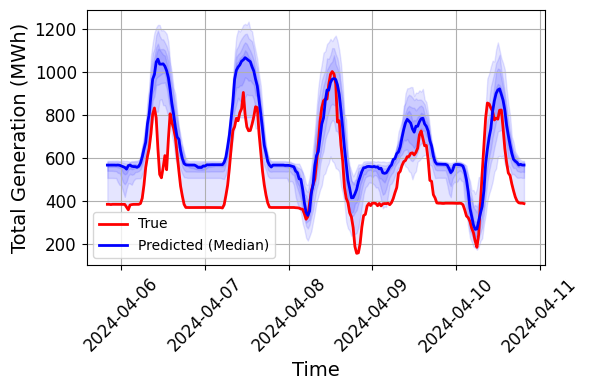

In [37]:
start_idx = 2200  
end_idx = 2440

n_q = len(quantiles)  # should match number of quantile columns
t_slice = y_time[start_idx:end_idx]  # your time vector
df_quant_slice = df_preds_new.iloc[start_idx:end_idx, :]  # aligned quantile predictions

plt.figure(figsize=(6, 4))

# Plot prediction intervals
for i in range(n_q // 2):
    lower = df_quant_slice.iloc[:, i]
    upper = df_quant_slice.iloc[:, -(i + 1)]
    plt.fill_between(t_slice, lower, upper, color='blue', alpha=0.1)

# Plot true and median prediction
plt.plot(t_slice, y_true_comp[start_idx:end_idx], label='True', color='red', linewidth=2)
plt.plot(t_slice, df_quant_slice["q50"], label='Predicted (Median)', color='blue', linewidth=2)


plt.xlabel("Time", fontsize=14)
plt.ylabel("Total Generation (MWh)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Pinball score Compition REMIT (Total): 31.8984
Pinball score Compition REMIT (Solar): 14.4788
Pinball score Compition REMIT (Wind):  27.1839


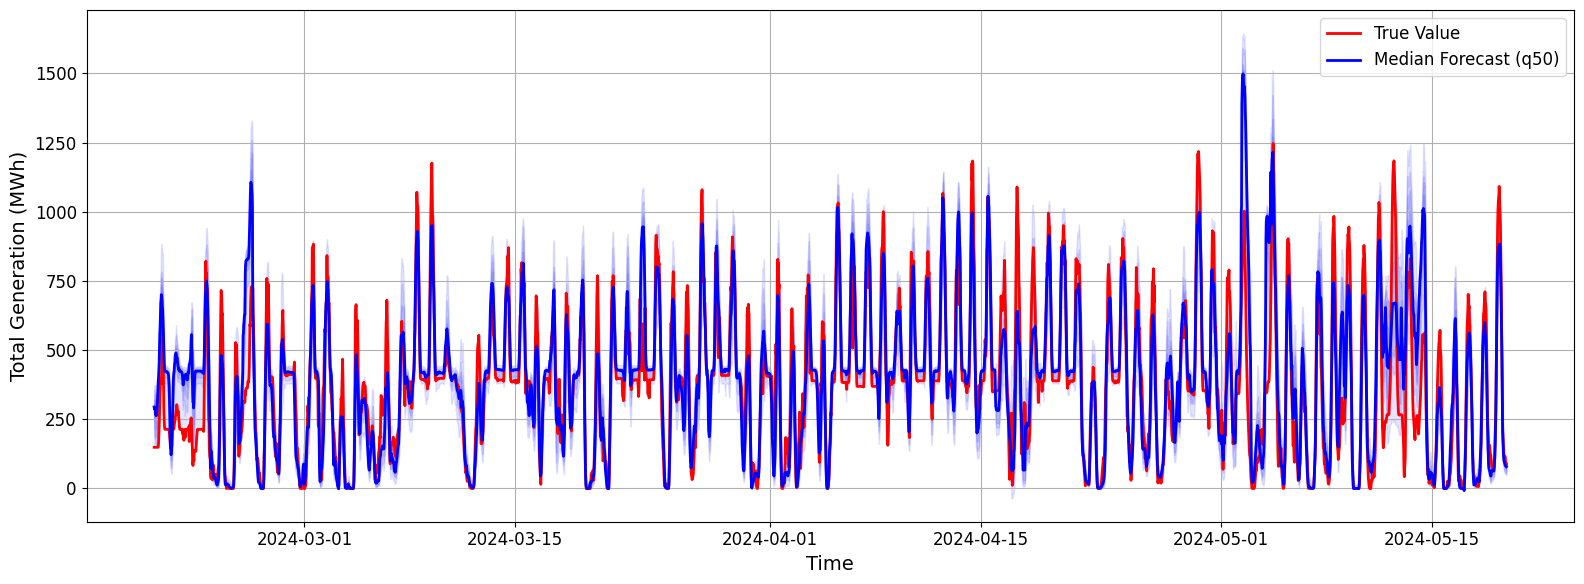

In [ ]:
# With Adjusted REMIT
# Single run test of most resently run model with REMIT
# Import REMIT
# NOTES about REMIT
# They're all for Hornsea 1 -> 1218 MW

df = pd.read_csv("data_comp/REMIT_capacity_comp.csv")
df["capacity_1_scaled"] = df["capacity_1"]/(400)
df["capacity_2_scaled"] = df["capacity_2"]/(400)
df["capacity_3_scaled"] = df["capacity_3"]/(400)
df["capacity_tot_scaled"] = (df["capacity_1_scaled"] + df["capacity_2_scaled"] + df["capacity_3_scaled"])

# take out limits for wind
capacity_scaled = df["capacity_tot_scaled"].to_numpy() 

# limit wind for all quantiles 
y_p_wind_scaled = {
    q: wind_preds_new[q]*capacity_scaled
    for q in wind_preds_new
}

# dfs for pinball scores
df_solar_new = pd.DataFrame({
    "total_generation_MWh": y_true_solar_comp,
    **{f"q{int(q*100)}": solar_preds_new[q] for q in quantiles}
})

# wind
df_wind_new = pd.DataFrame({
    "total_generation_MWh": y_true_wind_comp,
    **{f"q{int(q*100)}": y_p_wind_scaled[q] for q in quantiles}
})

# combined
df_preds_new = pd.DataFrame({
    "total_generation_MWh": y_true_comp,
    **{f"q{int(q*100)}": solar_preds_new[q] +  y_p_wind_scaled[q] for q in quantiles}
})
 
# score all three
score_total = pinball_score(df_preds_new)
score_solar = pinball_score(df_solar_new)
score_wind  = pinball_score(df_wind_new)

print(f"Pinball score Compition REMIT (Total): {score_total:.4f}")
print(f"Pinball score Compition REMIT (Solar): {score_solar:.4f}")
print(f"Pinball score Compition REMIT (Wind):  {score_wind:.4f}")

# plot to see predictions went down
# does size matter? 
plt.figure(figsize=(16, 6))
# plot true 
plt.plot(time, y_true_comp, label='True Value', linewidth=2,  color="red")

# Plot symmetric quantile bands (e.g. q10–q90, q20–q80, ...)
for i in range(n_q // 2):
    lower = df_preds_new.iloc[:, i]
    upper = df_preds_new.iloc[:, -(i + 1)]
    plt.fill_between(time, lower, upper, color='blue', alpha=0.1)

# plot median overlapp previous median 
plt.plot(time, df_preds_new["q50"].values, label="Median Forecast (q50)", linewidth=2, color="blue",)

plt.xlabel("Time", fontsize=14)
plt.ylabel("Total Generation (MWh)", fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# With Remit 
# Pinball score: 33.3320 (y and X scaled, no random search)
# Pinball score: 31.8984 (y and X scaled, with random search)

# for report
# With REMIT with search
# Pinball score Compition REMIT (Total): 31.8984
# Pinball score Compition REMIT (Solar): 14.4788
# Pinball score Compition REMIT (Wind):  27.1839

# With REMIT without search
#Pinball score Compition REMIT (Total): 33.3320
#Pinball score Compition REMIT (Solar): 14.5746
#Pinball score Compition REMIT (Wind):  29.0456


In [ ]:
# Calculate metrics

metrics_solar = evaluate_forecast(df_solar_new, quantiles)
metrics_wind = evaluate_forecast(df_wind_new, quantiles)
metrics_combined = evaluate_forecast(df_preds_new, quantiles)

print("Solar:", metrics_solar)
print("Wind:", metrics_wind)
print("Combined:", metrics_combined)

# With REMIT, no search
#Solar: {'MAE': 36.6008632696401, 'MAPE': np.float64(16417404.86791675), 'SMAPE': np.float64(109.34510697418445), 'RMSE': np.float64(77.06929821930994), 'R2': 0.8809229581503759, 'CRPS': np.float64(14.574564977067322), 'WIS': np.float64(164.94600140657906)}
#Wind: {'MAE': 70.17893239801344, 'MAPE': np.float64(439.71574758088076), 'SMAPE': np.float64(51.95448978098282), 'RMSE': np.float64(120.91515658177465), 'R2': 0.3441907420511182, 'CRPS': np.float64(29.045624514038213), 'WIS': np.float64(322.8032895465328)}
#Combined: {'MAE': 82.91014064926213, 'MAPE': np.float64(333.495115811197), 'SMAPE': np.float64(35.12168408183019), 'RMSE': np.float64(130.1410439914845), 'R2': 0.7375782871506338, 'CRPS': np.float64(33.332024974789334), 'WIS': np.float64(376.2920753607)}

# With REMIT, with search
#Solar: {'MAE': 36.13761989473823, 'MAPE': np.float64(9872374.07812566), 'SMAPE': np.float64(108.6501487641673), 'RMSE': np.float64(75.30158538061205), 'R2': 0.8863227737681374, 'CRPS': np.float64(14.478761773194323), 'WIS': np.float64(167.48660220270582)}
#Wind: {'MAE': 67.50390643857797, 'MAPE': np.float64(377.6705421117564), 'SMAPE': np.float64(51.02573745826301), 'RMSE': np.float64(118.1880088982833), 'R2': 0.37343967593321026, 'CRPS': np.float64(27.18385891184973), 'WIS': np.float64(309.76996971319164)}
#Combined: {'MAE': 80.48065131635165, 'MAPE': np.float64(324.59188865387085), 'SMAPE': np.float64(34.1925954736134), 'RMSE': np.float64(127.19675421342644), 'R2': 0.7493179419057958, 'CRPS': np.float64(31.898361738284873), 'WIS': np.float64(369.8738987218633)

Solar: {'MAE': 36.13761989473823, 'MAPE': np.float64(9872374.07812566), 'SMAPE': np.float64(108.6501487641673), 'RMSE': np.float64(75.30158538061205), 'R2': 0.8863227737681374, 'CRPS': np.float64(14.478761773194323), 'WIS': np.float64(167.48660220270582)}
Wind: {'MAE': 67.50390643857797, 'MAPE': np.float64(377.6705421117564), 'SMAPE': np.float64(51.02573745826301), 'RMSE': np.float64(118.1880088982833), 'R2': 0.37343967593321026, 'CRPS': np.float64(27.18385891184973), 'WIS': np.float64(309.76996971319164)}
Combined: {'MAE': 80.48065131635165, 'MAPE': np.float64(324.59188865387085), 'SMAPE': np.float64(34.1925954736134), 'RMSE': np.float64(127.19675421342644), 'R2': 0.7493179419057958, 'CRPS': np.float64(31.898361738284873), 'WIS': np.float64(369.8738987218633)}


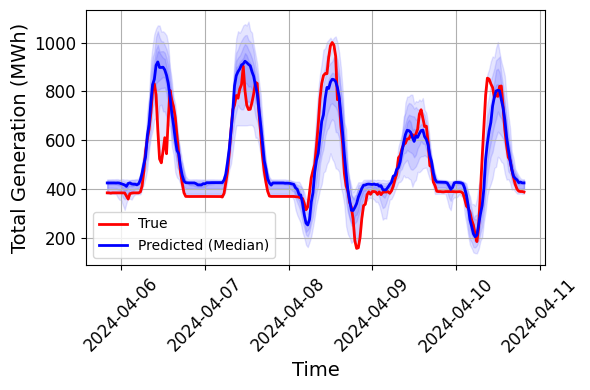

In [40]:
# plotting 
start_idx = 2200  
end_idx = 2440

n_q = len(quantiles)  # should match number of quantile columns
t_slice = y_time[start_idx:end_idx]  # your time vector
df_quant_slice = df_preds_new.iloc[start_idx:end_idx, :]  # aligned quantile predictions

plt.figure(figsize=(6, 4))

# Plot prediction intervals
for i in range(n_q // 2):
    lower = df_quant_slice.iloc[:, i]
    upper = df_quant_slice.iloc[:, -(i + 1)]
    plt.fill_between(t_slice, lower, upper, color='blue', alpha=0.1)

# Plot true and median prediction
plt.plot(t_slice, y_true_comp[start_idx:end_idx], label='True', color='red', linewidth=2)
plt.plot(t_slice, df_quant_slice["q50"], label='Predicted (Median)', color='blue', linewidth=2)


plt.xlabel("Time", fontsize=14)
plt.ylabel("Total Generation (MWh)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


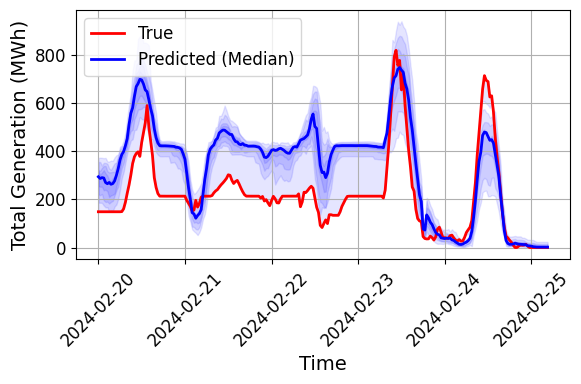

In [ ]:
# Get inaccurate predictions
start_idx = 0  
end_idx = 250

n_q = len(quantiles)  # should match number of quantile columns
t_slice = y_time[start_idx:end_idx]  # your time vector
df_quant_slice = df_preds_new.iloc[start_idx:end_idx, :]  # aligned quantile predictions

plt.figure(figsize=(6, 4))

# Plot prediction intervals
for i in range(n_q // 2):
    lower = df_quant_slice.iloc[:, i]
    upper = df_quant_slice.iloc[:, -(i + 1)]
    plt.fill_between(t_slice, lower, upper, color='blue', alpha=0.1)

# Plot true and median prediction
plt.plot(t_slice, y_true_comp[start_idx:end_idx], label='True', color='red', linewidth=2)
plt.plot(t_slice, df_quant_slice["q50"], label='Predicted (Median)', color='blue', linewidth=2)


plt.xlabel("Time", fontsize=14)
plt.ylabel("Total Generation (MWh)", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

